In [5]:
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score 


In [30]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
def display(img_):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    plt.subplot(111)
    plt.imshow(img)
    #plt.axis('off')
    plt.show
def segment_characters(img) :
    img_lp = cv2.resize(img, (275, 184))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

   # LP_HEIGHT = img_binary_lp.shape[0]
   # LP_WIDTH = img_binary_lp.shape[1]

    img_binary_lp[:5 :] = 255
    img_binary_lp[-5:, :] = 255
    img_binary_lp[:, :5] = 255
    img_binary_lp[:, -5:] = 255

    dimensions = [20,
                       92,
                       27.5,
                       183.3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    char_list = find_contours(dimensions, img_binary_lp)

    return char_list
def find_contours(dimensions, img) :

    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:13]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX)
            
            char_copy = np.zeros((44,24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            center_y = intY + intHeight // 2
            char = cv2.subtract(255, char)
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append((center_y, intX, char_copy)) 
          
    plt.show()
    img_res = sorted(img_res, key=lambda x: (x[0] > 92, x[0] < 92, x[1]))
    img_res = [char[2] for char in img_res]
    img_res = np.array(img_res)

    return img_res

In [7]:
import pygame
import time

class SoundManager:
    def __init__(self):
        self.sound_file_path = "tieng-chuong-thong-bao-dong-ho-casio-keu-1-lan-www_tiengdong_com.mp3"
        self.is_initialized = False

    def initialize(self):
        pygame.init()
        pygame.mixer.init()
        self.is_initialized = True

    def play_sound(self):
        if not self.is_initialized:
            self.initialize()

        try:
            for _ in range(6): 
                sound = pygame.mixer.Sound(self.sound_file_path)
                sound.play()
                time.sleep(sound.get_length())
        except pygame.error as e:
            print(f"Error playing sound: {e}")
sound_manager = SoundManager()


In [8]:
data_folder = 'archive/data/datatonghop4'
def load_data(folder_path):
    data = []
    labels = []
    
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (28, 28))
            data.append(img)
            labels.append(label)
    
    return np.array(data), np.array(labels)

train_img, train_labels = load_data(os.path.join(data_folder, 'train'))
test_img, test_labels = load_data(os.path.join(data_folder, 'val'))

label_to_index = {label: i for i, label in enumerate(np.unique(train_labels))}
train_labels = np.array([label_to_index[label] for label in train_labels])
test_labels = np.array([label_to_index[label] for label in test_labels])

test_img, val_img, test_labels, val_labels = train_test_split(test_img, test_labels, test_size=0.5, random_state=42)
labels = os.listdir(os.path.join(data_folder, 'train'))

train_img = train_img.astype('float32') / 255.0
val_img = val_img.astype('float32') / 255.0
test_img = test_img.astype('float32') / 255.0

print("class:",len(labels))
print("Train image:", len(train_img))
print("Validation image:", len(val_img))
print("Test image:", len(test_img))


class: 30
Train image: 2255
Validation image: 764
Test image: 763


In [9]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                      

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('best_model_4+_w.h5', save_best_only=True)
history = model.fit(train_img, train_labels, epochs=50, batch_size=4,
                    validation_data=(val_img, val_labels)
                    #, callbacks=[early_stopping,model_checkpoint]
                   )
sound_manager.play_sound()

Epoch 1/50


564/564 [==============================] - 47s 80ms/step - loss: 3.2856 - accuracy: 0.1264 - val_loss: 2.4823 - val_accuracy: 0.4162
Epoch 2/50
564/564 [==============================] - 42s 74ms/step - loss: 2.0092 - accuracy: 0.4293 - val_loss: 1.1887 - val_accuracy: 0.6963
Epoch 3/50
564/564 [==============================] - 41s 73ms/step - loss: 1.2098 - accuracy: 0.6364 - val_loss: 0.6610 - val_accuracy: 0.8272
Epoch 4/50
564/564 [==============================] - 44s 78ms/step - loss: 0.8372 - accuracy: 0.7401 - val_loss: 0.4638 - val_accuracy: 0.8665
Epoch 5/50
564/564 [==============================] - 45s 80ms/step - loss: 0.6415 - accuracy: 0.7991 - val_loss: 0.3628 - val_accuracy: 0.8940
Epoch 6/50
564/564 [==============================] - 52s 92ms/step - loss: 0.5224 - accuracy: 0.8337 - val_loss: 0.2606 - val_accuracy: 0.9306
Epoch 7/50
564/564 [==============================] - 65s 115ms/step - loss: 0.4231 - accuracy: 0.8612 - val_loss: 0.2361 - val_accura

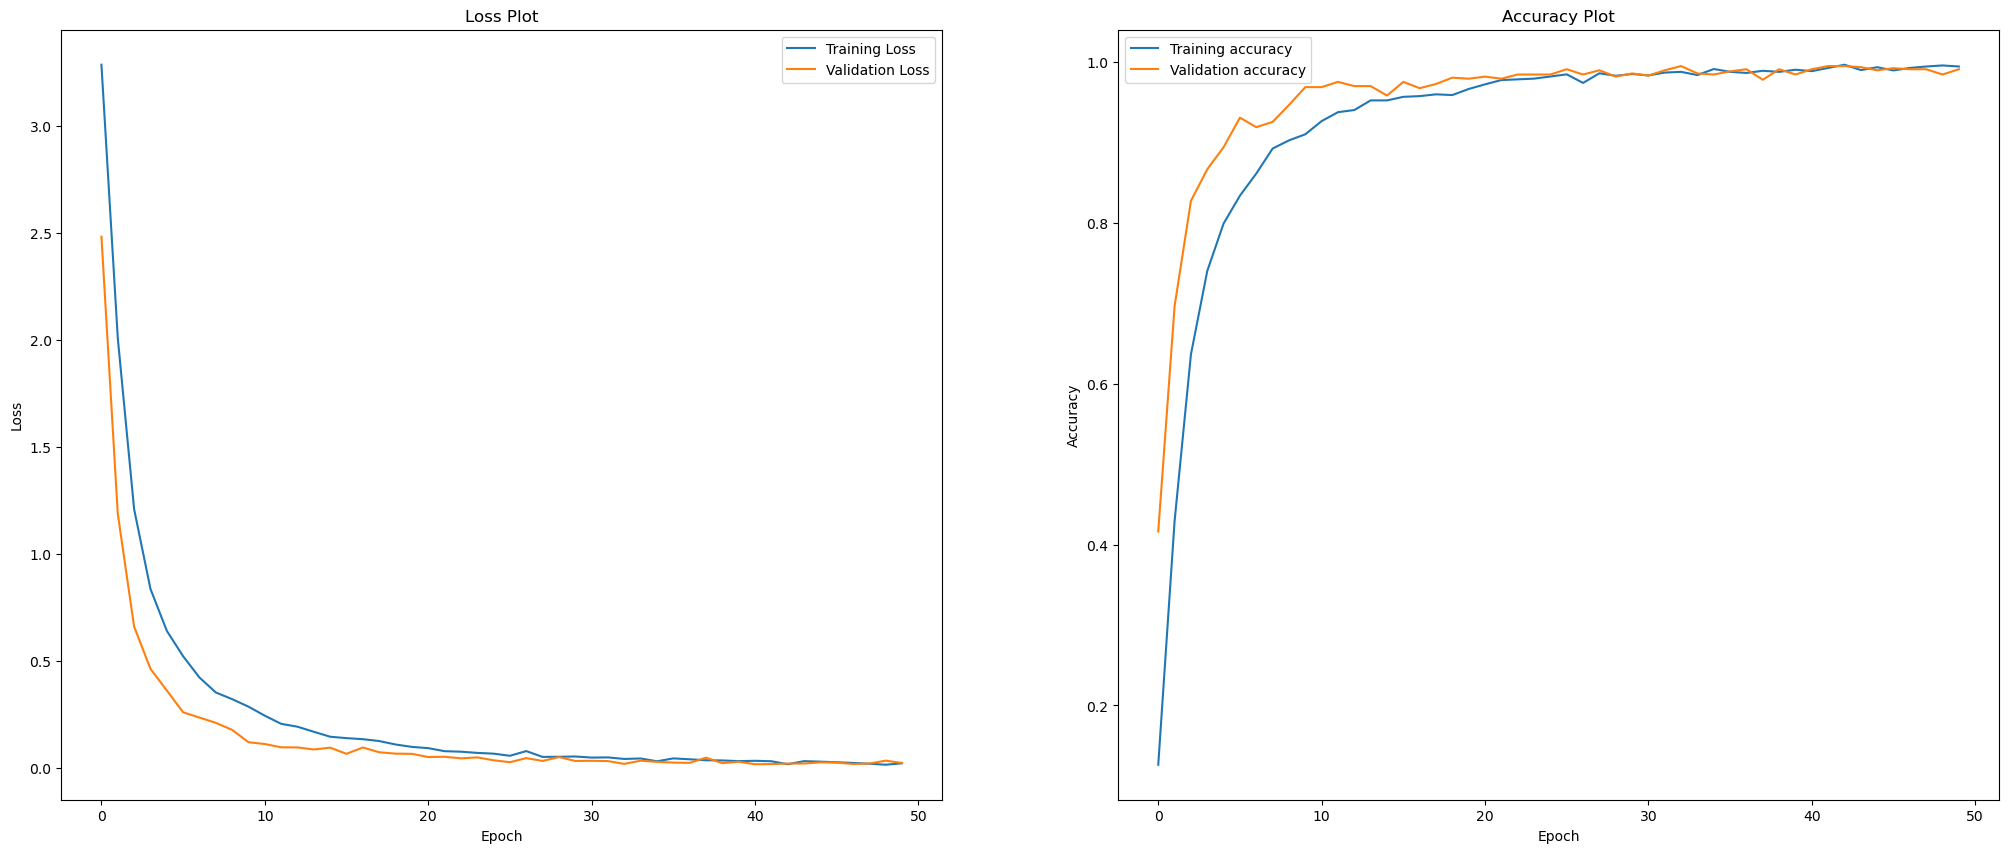

In [12]:
import matplotlib.pyplot as plt 
fig,ax=plt.subplots(1,2,figsize=(25,10))
ax[0].plot(history.history["loss"],label="Training Loss")
ax[0].plot(history.history["val_loss"],label="Validation Loss")
ax[0].set_title("Loss Plot")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].legend()

ax[1].plot(history.history["accuracy"],label="Training accuracy")
ax[1].plot(history.history["val_accuracy"],label="Validation accuracy")
ax[1].set_title("Accuracy Plot")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()

plt.show()

In [71]:
test_loss, test_acc = model.evaluate(test_img,  test_labels, verbose=2)
print(test_acc)

24/24 - 2s - loss: 0.0085 - accuracy: 0.9987 - 2s/epoch - 65ms/step
0.9986894130706787


In [31]:
def fix_dimension(image): 
    img = np.zeros((28, 28, 3))
    for i in range(3):
        img[:,:,i] = image
    return img
def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHKLMNPSTUVXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):
        image_ = cv2.resize(ch, (28, 28), interpolation=cv2.INTER_AREA)
        image = fix_dimension(image_)
        image = image.reshape(1, 28, 28, 3)
        predictions = model.predict(image)
        y_ = np.argmax(predictions[0])
        characters = dic[y_]
        output.append(characters)
        
    plate_number = ''.join(output)
    return plate_number
def show(image_path):
    img = cv2.imread(image_path)
    char = segment_characters(img)
    plate_number = show_results(char)
    return plate_number

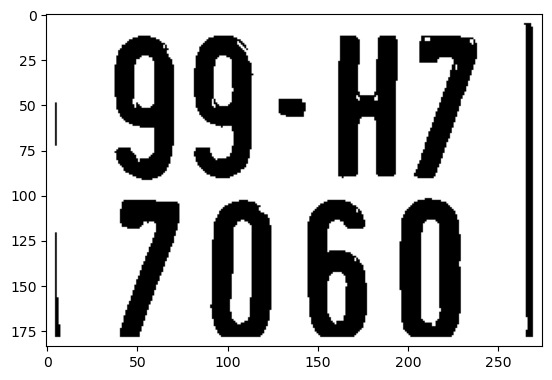

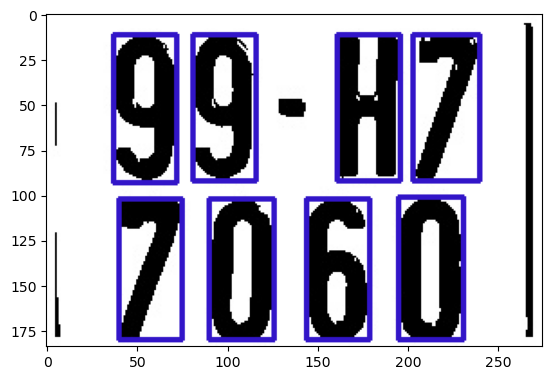

1/1 [==============================] - 0s 26ms/step


'99H77060'

In [32]:
show('bienso/bien.jpg')

In [63]:
model.save('best_model_4.keras')

In [72]:
model = load_model('best_model_4.keras')

24/24 [==============================] - 1s 55ms/step


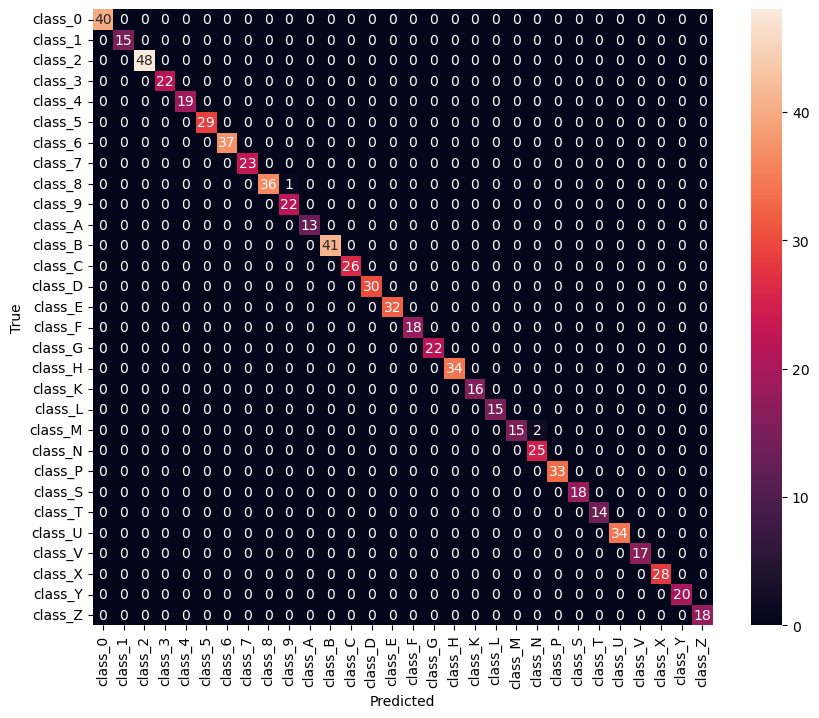

In [73]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

predictions = model.predict(test_img)
predicted_labels = np.argmax(predictions, axis=1)

predicted_labels = [labels[i] for i in predicted_labels]
true_labels = [labels[i] for i in test_labels]

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True,xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#print(classification_report(true_labels, predicted_labels, target_names=labels))


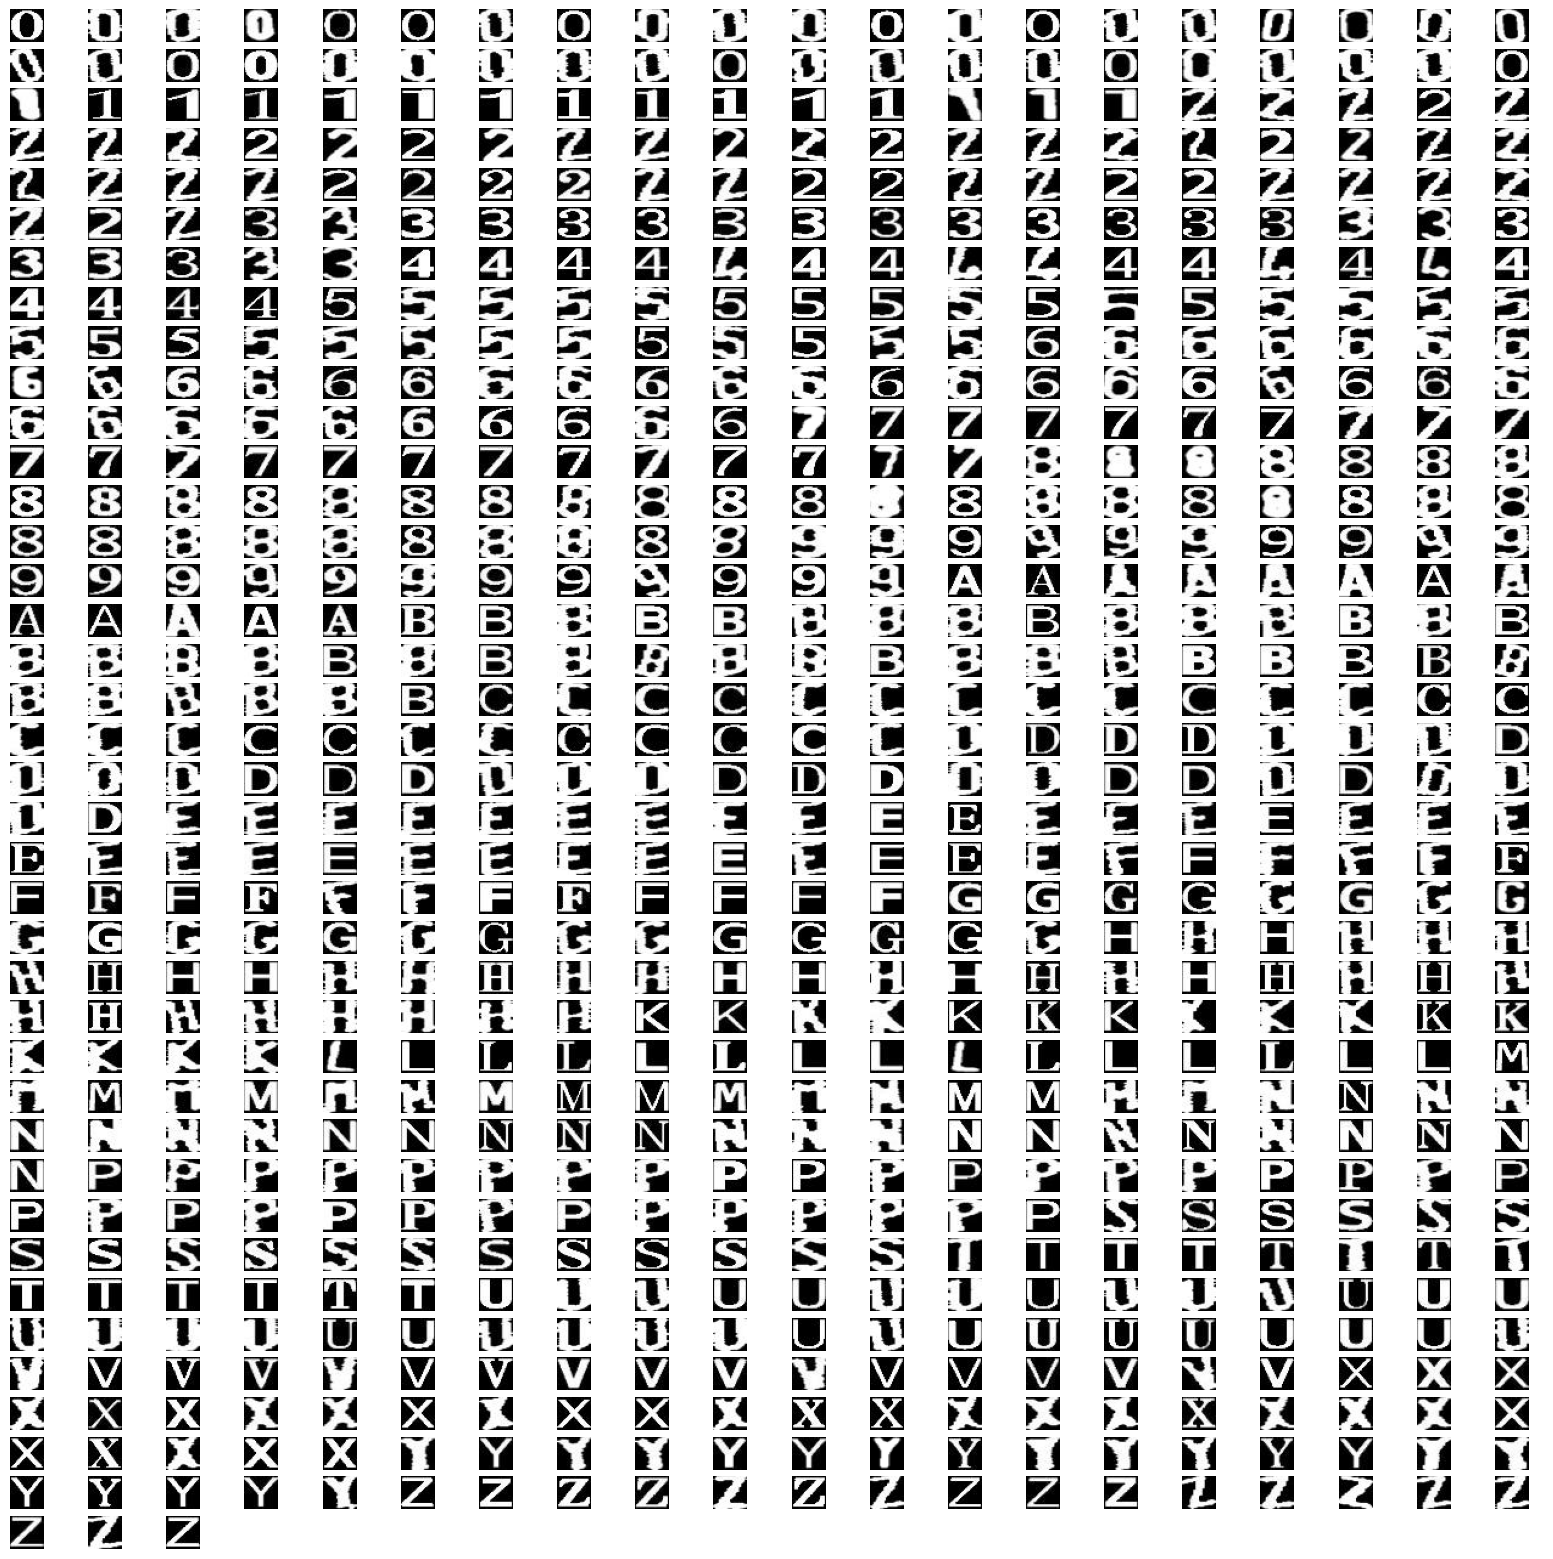

In [74]:
import math

sorted_indices = np.argsort(test_labels)
sorted_test_img = test_img[sorted_indices]
sorted_test_labels = test_labels[sorted_indices]

num_images = len(sorted_test_img)
num_rows = int(math.ceil(num_images / 20))

fig, axes = plt.subplots(num_rows, 20, figsize=(20, 20))

for i in range(num_rows):
    for j in range(20):
        index = i * 20 + j

        if index < num_images:
            axes[i, j].imshow(sorted_test_img[index])
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')

plt.show()


In [75]:
from collections import Counter

test_label_counts = Counter(test_labels)
sorted_counts = sorted(test_label_counts.items(), key=lambda x: x[0])

for label, count in sorted_counts:
    print(f" {label}: {count} ")


 0: 40 
 1: 15 
 2: 48 
 3: 22 
 4: 19 
 5: 29 
 6: 37 
 7: 23 
 8: 37 
 9: 22 
 10: 13 
 11: 41 
 12: 26 
 13: 30 
 14: 32 
 15: 18 
 16: 22 
 17: 34 
 18: 16 
 19: 15 
 20: 17 
 21: 25 
 22: 33 
 23: 18 
 24: 14 
 25: 34 
 26: 17 
 27: 28 
 28: 20 
 29: 18 


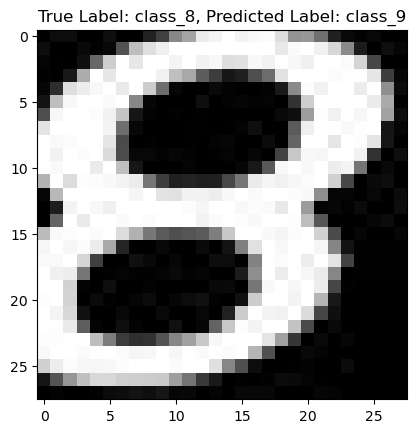

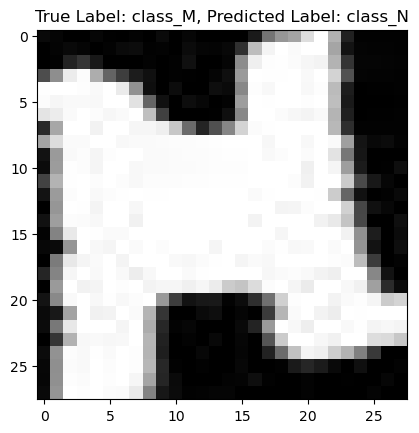

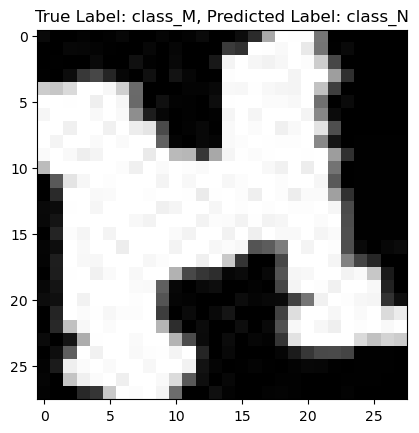

In [76]:
incorrect = [i for i in range(len(true_labels)) if true_labels[i] != predicted_labels[i]]
for incorrect_index in incorrect:
    plt.imshow(test_img[incorrect_index])
    true_label = true_labels[incorrect_index]
    predicted_label = predicted_labels[incorrect_index]
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.show()
